In [1895]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import time
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [1896]:
#basename="20170815-124442-7302"
#basename="20170804-141819-2381"
#basename="20170816-080251-1751"
#basename="20170815-200017-20631"
#basename="20170815-140458-9678"
#basename="20170815-140218-9605"
#basename="20170815-134141-8984" # two sailing boats
#basename="20170815-131437-8189" # motor cruiser
#basename="20170815-114957-5681"  # canoes
basename="20170815-092746-1661"  #spirit of kinsale
#basename="20170821-153703-0"  # single large whole image
#basename="20170821-195214-92"  # large number of contours

fmaskedimage = 'C:/Boats/Images/maskedimage-{}.jpg'.format(basename)
frawimage = 'C:/Boats/Images/raw-{}.jpg'.format(basename)
maskedimage = cv2.imread(fmaskedimage,0)
rawimage = cv2.imread(frawimage,0)
crawimage = cv2.imread(frawimage)

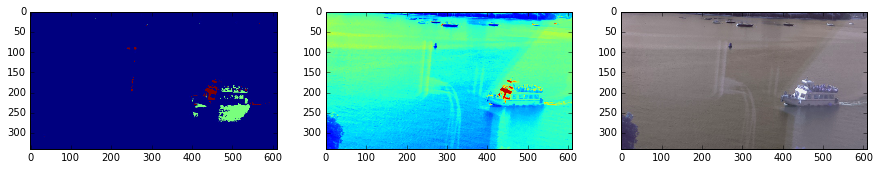

In [1897]:
fig=plt.figure()
a=fig.add_subplot(1,3,1)
plt.imshow(maskedimage)
a=fig.add_subplot(1,3,2)
plt.imshow(rawimage)
a=fig.add_subplot(1,3,3)
plt.imshow(crawimage)
plt.show()

In [1898]:
(thresh, im_bw) = cv2.threshold(maskedimage, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
edges = cv2.Canny(im_bw, 100, 200)

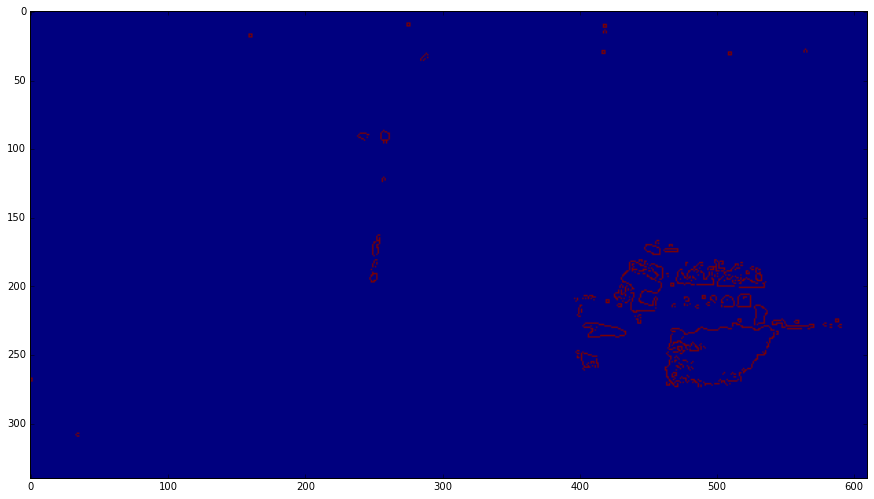

In [1899]:
plt.imshow(edges)

In [1900]:
class Point:
    def __init__(self, xcoord=0, ycoord=0):
        self.x = xcoord
        self.y = ycoord
    
    def dist(self, other):
        return math.hypot(abs(other.x - self.x), abs(other.y- self.y))

    def __str__(self):
        return "Point: x:{} y:{}".format(self.x,self.y)
        
class Rectangle:
    def __init__(self, top_left, bottom_right):
        self.top_left = top_left
        self.bottom_right = bottom_right

    def intersects_x(self, other):
        return (self.top_left.x <= other.bottom_right.x) and (other.top_left.x <= self.bottom_right.x)
    
    def intersects_y(self, other):
        return (self.top_left.y <= other.bottom_right.y) and (other.top_left.y <= self.bottom_right.y)
        
    def contains(self, other):
        return self.top_left.x < other.top_left.x < other.bottom_right.x < self.bottom_right.x and \
                    self.top_left.y < other.top_left.y < other.bottom_right.y < self.bottom_right.y
        
    def adjacent(self, other):
        adjacent_x =  (abs(self.top_left.x - other.bottom_right.x) <= 1 or \
               abs(self.bottom_right.x - other.top_left.x) <= 1) and self.intersects_y(other)
        adjacent_y = (abs(self.top_left.y - other.bottom_right.y) <= 1 or \
               abs(self.bottom_right.y - other.top_left.y) <= 1) and self.intersects_x(other)
        return adjacent_x or adjacent_y
                
    def merge(self, other):
        tl = Point(min(self.top_left.x, other.top_left.x), min(self.top_left.y, other.top_left.y))
        br = Point(max(self.bottom_right.x, other.bottom_right.x), max(self.bottom_right.y, other.bottom_right.y))
        return Rectangle(tl, br)
    
    def __str__(self):
        return "Rectangle: top_left: {} bottom_right: {} ".format(self.top_left, self.bottom_right)

In [1901]:
im2, contours, hierarchy = cv2.findContours(im_bw, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
print("Number contours:", len(contours))

Number contours: 152


In [1902]:
#http://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html
newcontours = []
for c in contours:
    area = cv2.contourArea(c)
    if area > 5:
        newcontours.append(c)
contours = newcontours
print("Number of contours:", len(contours))

Number of contours: 31


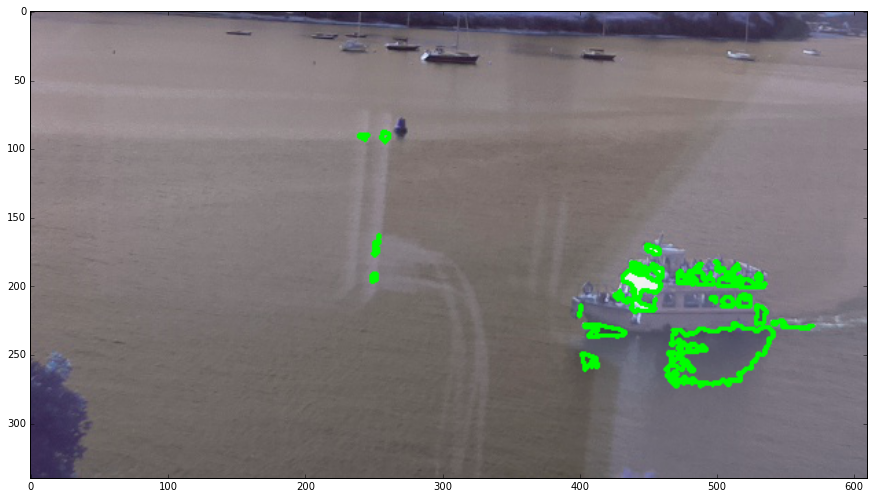

In [1903]:
crawimage = cv2.imread(frawimage)
cv2.drawContours(crawimage,contours,-1,(0,255,0),2)
plt.imshow(crawimage)

In [1904]:
mindist = 1
minradius = 0

def buildcontourlist(contours):
    contourlist = []
    for c in contours:
        center, radius = cv2.minEnclosingCircle(c)
        contourlist.append((c, center, radius))
    return contourlist

def getfirstcandidate(contourlist):
    for i in range(len(contourlist)):
        ith = contourlist[i]
        for j in range(i+1, len(contourlist)):
            jth = contourlist[j]
            # distance between two centers
            d = math.hypot(abs(ith[1][0] - jth[1][0]), abs(ith[1][1]- jth[1][1]))
            # subtract sum of two radii
            d -= (ith[2] + jth[2])
            if d < mindist:
                return (int(round(d)), i, j)
    return (mindist + 1, 0, 0)

def mergecontours(ith, jth, contours, contourlist):
    cont = np.vstack(contours[i] for i in [ith, jth])
    merged = cv2.convexHull(cont)
    contours = [c for i, c in enumerate(contours) if i not in [ith, jth]]
    contourlist = [c for i, c in enumerate(contourlist) if i not in [ith, jth]]
    contours.append(merged)
    center, radius = cv2.minEnclosingCircle(merged)
    contourlist.append((merged, center, radius))
    return (contours, contourlist)

print("Before ", len(contours))
t0 = time.time()
contourlist = buildcontourlist(contours)
t0 = time.time()
total=0
while True:
    t0 = time.time()
    d, ith, jth = getfirstcandidate(contourlist)
    t1 = time.time()
    total += (t1-t0)
    if d > mindist:
        break
    contours, contourlist = mergecontours(ith, jth, contours, contourlist)
    
print("After ", len(contours), total)
unified = contours

Before  31
After  5 0.0010006427764892578


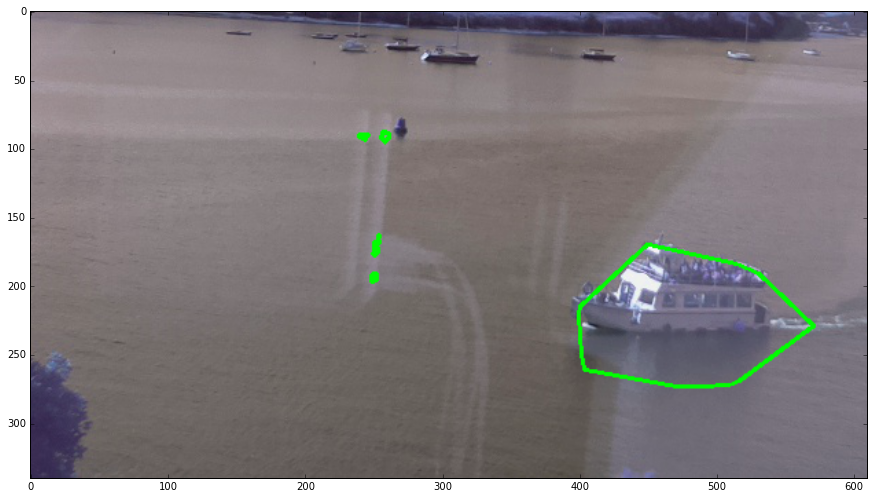

In [1905]:
crawimage = cv2.imread(frawimage)
_ = cv2.drawContours(crawimage,contours,-1,(0,255,0),2)
plt.imshow(crawimage)

In [1906]:
# see if a contour is  contained in another
toremove=[]
for i, c1 in enumerate(unified):
    for j, c2 in enumerate(unified):
        if i != j:
            m2 = cv2.moments(c2)
            cX = int(m2["m10"] / m2["m00"])
            cY = int(m2["m01"] / m2["m00"])
            if cv2.pointPolygonTest(c1, (cX, cY), False) > 0:
                toremove.append(j)
toremove=set(toremove)
unified = [c for i, c in enumerate(unified) if i not in toremove ]
# contained contours now removed

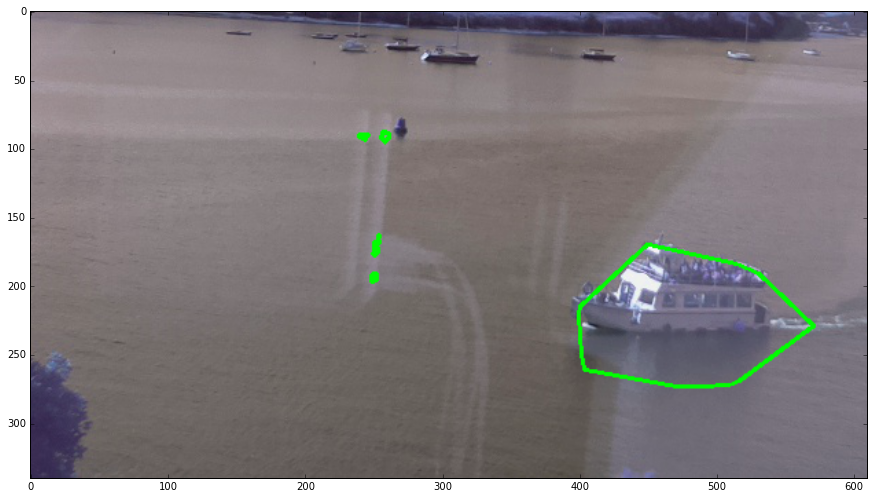

In [1907]:
crawimage = cv2.imread(frawimage)
_ = cv2.drawContours(crawimage,unified,-1,(0,255,0),2)
plt.imshow(crawimage)

In [1908]:
# remove contours whose bounding rectangle is in another contour's bounding rectangle
rectangles=[]
for i, c in enumerate(unified):
    x, y, w,h = cv2.boundingRect(c)
    rectangles.append(Rectangle(Point(x, y), Point(x + w, y + h)))
    
toremove=[]
for i, r1 in enumerate(rectangles):
    for j, r2 in enumerate(rectangles):
        if i != j:
            if r1.contains(r2):
                toremove.append(j)
toremove=set(toremove)
unified = [c for i, c in enumerate(unified) if i not in toremove]
rectangles = [r for i, r in enumerate(rectangles) if i not in toremove] 
#contained rectangles removed 

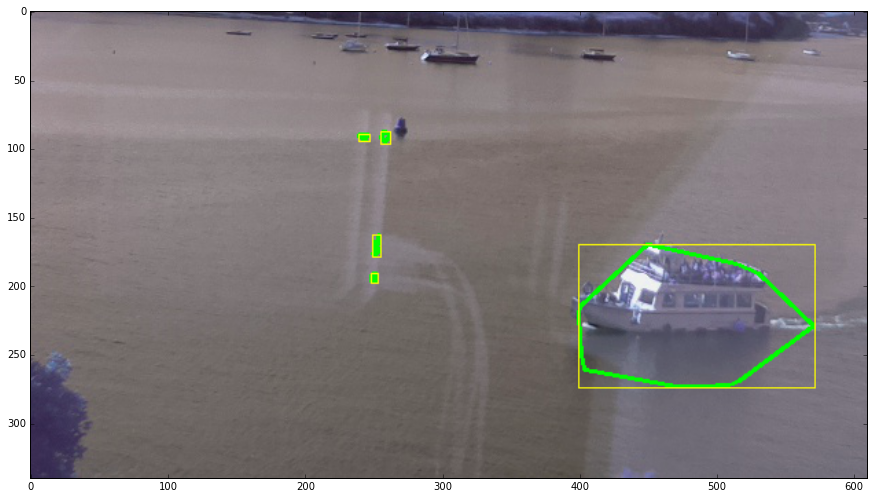

In [1909]:
crawimage = cv2.imread(frawimage)
_ = cv2.drawContours(crawimage,unified,-1,(0,255,0),2)
for r in rectangles:
    _ = cv2.rectangle(crawimage, (r.top_left.x, r.top_left.y), (r.bottom_right.x, r.bottom_right.y), (255, 255,0))
plt.imshow(crawimage)

In [1910]:
# merge adjacent bounding rectangles

def mergerectangles(rects):
    for i, r1 in enumerate(rects):
        for j, r2 in enumerate(rects):
            if i != j and r1.adjacent(r2):
                rects = [r for rn, r in enumerate(rects) if rn != i and rn != j ]
                rects.append(r1.merge(r2))
                print("Merge: {} and {}".format(r1, r2))
                return (True, rects)
    return (False, rects)

print("Length rectangles before merging:", len(rectangles))
loop = True
while loop:
    loop, rectangles = mergerectangles(rectangles)
print("Length rectangles after merging:", len(rectangles))


Length rectangles before merging: 5
Length rectangles after merging: 5


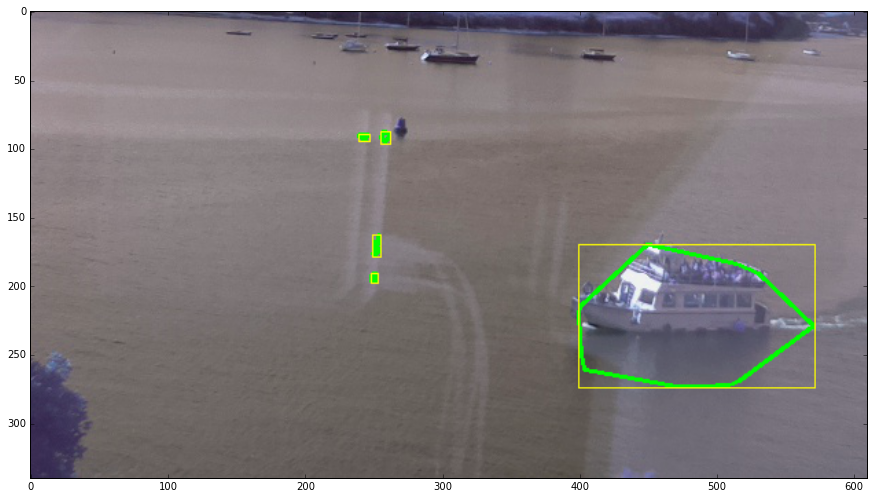

In [1911]:
crawimage = cv2.imread(frawimage)
_ = cv2.drawContours(crawimage,unified,-1,(0,255,0),2)
for r in rectangles:
    _ = cv2.rectangle(crawimage, (r.top_left.x, r.top_left.y), (r.bottom_right.x, r.bottom_right.y), (255, 255,0))
plt.imshow(crawimage)

In [1912]:
ships=[]

crawimage = cv2.imread(frawimage)

for idx, r in enumerate(rectangles):
    roi = crawimage[r.top_left.y:r.bottom_right.y, r.top_left.x:r.bottom_right.x]
    ships.append(roi)

In [1913]:
print("Number ship candidates:", len(ships))

Number ship candidates: 5


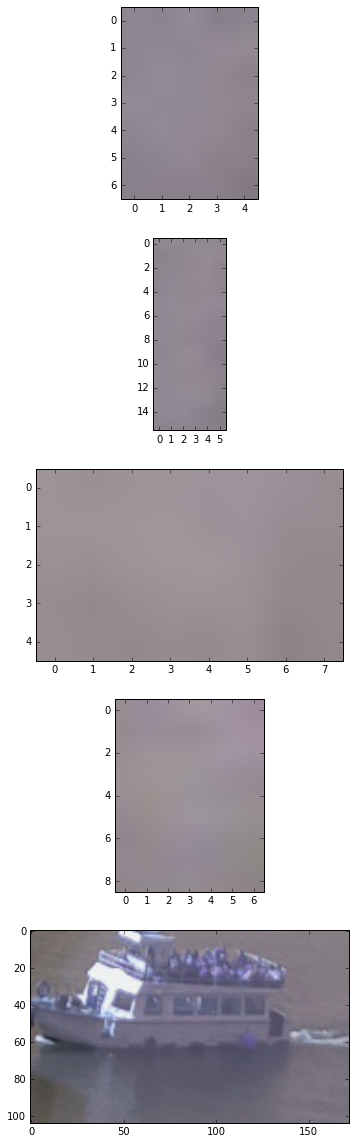

In [1914]:
fig=plt.figure(figsize = (20, 20))
for i, img in enumerate(ships):
    a=fig.add_subplot(len(ships), 1, i+1)
    plt.imshow(img)

In [1915]:
dnnmodel = 'C:/Boats/isaboat.ckpt'
dnnmetamodel = 'C:/Boats/isaboat.ckpt.meta'
std_image_size_x = 80
std_image_size_y = 20

In [1916]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
reset_graph()

In [1917]:
dnnmodel = 'C:/Boats/isaboat.ckpt'
dnnmetamodel = 'C:/Boats/isaboat.ckpt.meta'
reset_graph()

In [1918]:
init = tf.global_variables_initializer()
saver = tf.train.import_meta_graph(dnnmetamodel)

In [1919]:
def normalizeimage(img):
    img = cv2.resize(img, (std_image_size_x, std_image_size_y)) 
    norm_image = np.zeros((std_image_size_x, std_image_size_y))
    norm_image = cv2.normalize(img,  norm_image, 0, 255, cv2.NORM_MINMAX)
    norm_image = norm_image.flatten()
    return norm_image

In [1920]:
Xclasslist = []
Yclasslist = []

for img in ships:
    norm_image = normalizeimage(img)
    Xclasslist.append(norm_image)
Xclassd = np.array(Xclasslist, dtype=np.float32)

In [1921]:
validships = []
with tf.Session() as sess:
    saver.restore(sess,dnnmodel)
    # predict those to be classified
    graph = tf.get_default_graph()
    logits = graph.get_tensor_by_name('output/output/BiasAdd:0')
    Z = logits.eval(feed_dict={'inputs/X:0': Xclassd})
    y_pred = np.argmax(Z, axis=1)
    for i, cl in enumerate(y_pred):
        #print("Prediction:", i, cl)
        if cl == 1:
            validships.append(i)
print(validships)

INFO:tensorflow:Restoring parameters from C:/Boats/isaboat.ckpt
[4]


In [1922]:
Z, y_pred

(array([[ 36.29789352,  21.14031219],
        [ 60.80932999,  35.78591537],
        [ 39.65772629,  21.87538528],
        [ 53.9894104 ,  32.74616241],
        [-12.87799549,  -5.9339757 ]], dtype=float32),
 array([0, 0, 0, 0, 1], dtype=int64))

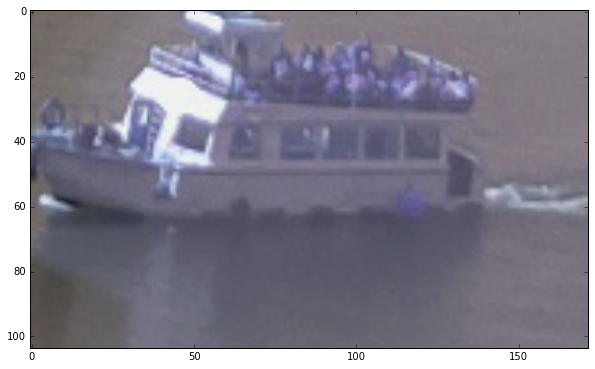

In [1923]:
fig=plt.figure(figsize = (10, 10))
for i, indx in enumerate(validships):
    a=fig.add_subplot(len(validships), 1, i+1)
    img=ships[indx]
    plt.imshow(img)